In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random
from datetime import datetime


warnings.filterwarnings('ignore')

In [2]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'DAoptostimulation_Mar22'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


### Analysis of tStr unilateral stimulation

In [53]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [54]:
# Select stimulation in tStr
fib_loc_num = 1
fln_mask = [x['FiberLocation'] == fib_loc_num for x in pulledData.FullGUI]
pulledData = pulledData.iloc[fln_mask]

In [55]:
# Because we are going to look at the subsequent trial,
# I will 'hack' the dataframe and classify as optostimulated trials,
# the in which the stimulation happened in the trial before.
# That way I can make use of the functions available for analysis

pulledData.OptoStim = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)

In [56]:
# Select only those trials where the previous trial is a success
pulledData = pulledData[pulledData.PrevTrialSuccess == 1]

In [57]:
# Select only those trials where the previous trial is contralateral to the fiber
# 1 is left poke
# 2 is right poke

pulledData['PreviousSide'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            side_prev = pulledData.loc[idx_prev].TrialSide
        else:
            side_prev = np.nan

        pulledData.at[idx, 'PreviousSide'] = side_prev

In [58]:
# Do the selection
idxs_to_keep = []
for session_id in pulledData.SessionID.unique():
    session_data = pulledData[pulledData.SessionID == session_id]
    stim_side = session_data.Stimulation.unique()[0]
    if stim_side == 'Right':
        idxs_to_keep.append(session_data[session_data.PreviousSide == 1].index)
    if stim_side == 'Left':
        idxs_to_keep.append(session_data[session_data.PreviousSide == 2].index)

# flatten
idxs_to_keep_flat = [item for sublist in idxs_to_keep for item in sublist]

#select
pulledData = pulledData.loc[idxs_to_keep_flat]

In [59]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [60]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [61]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [62]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
# random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

In [63]:
pulledData['PreviousOpto'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            opto_prev = pulledData.loc[idx_prev].OptoStim
        else:
            opto_prev = np.nan

        pulledData.at[idx, 'PreviousOpto'] = opto_prev

Progress: [####################] 100.0%


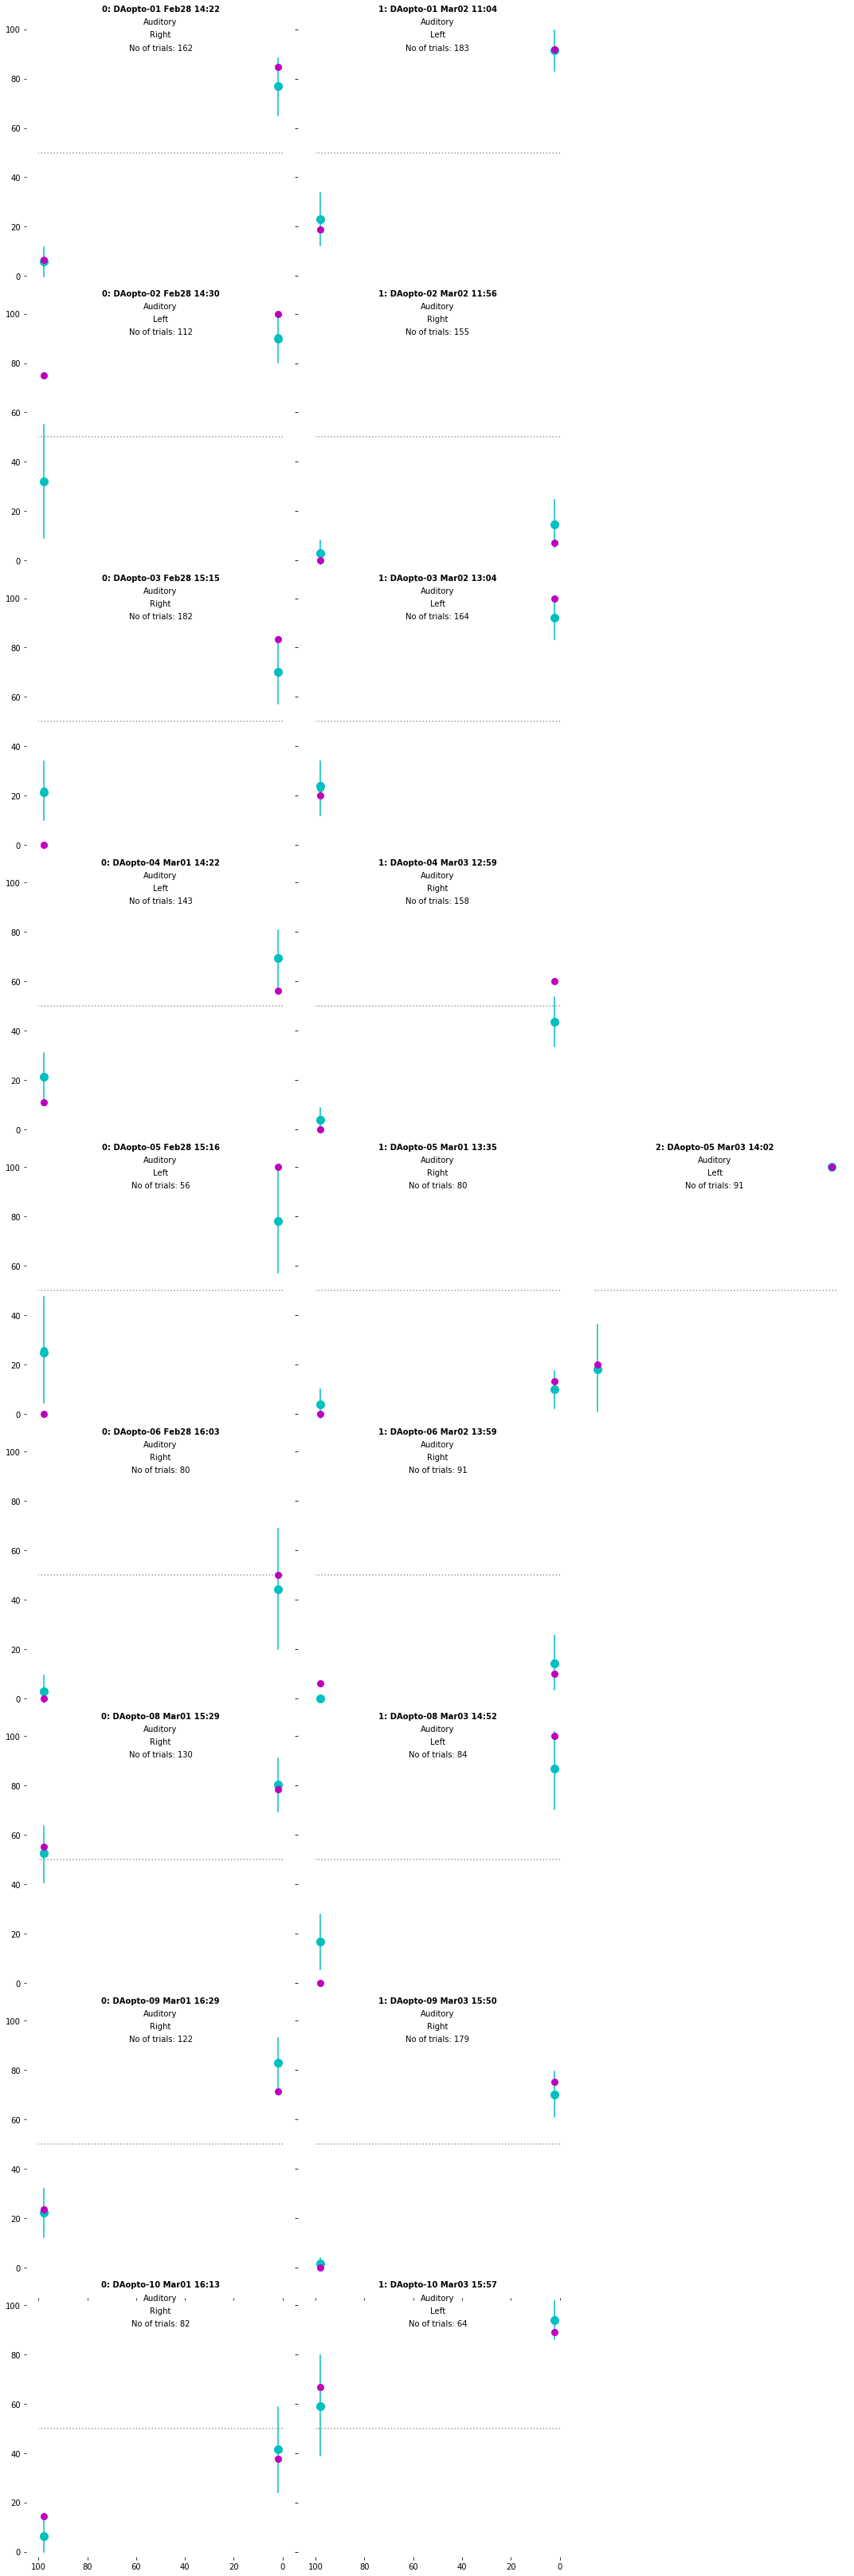

In [65]:
# Plot the data with the error bars for the random sampling

# CondList = [(pulledData['PreviousOpto']==0),
#             (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Previous Normal', 'Previous Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
# n_cols = 2

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
        # overlay fits
#         for i, condition in enumerate(CondList):
#             plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
#                                        color=ColorList[i], label=LabelList[i], plot_points=True)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_previous_tStr.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

### nAc stimulation

In [57]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [58]:
#Subselect dataset psychometric
pulledData = pulledData[pulledData.Protocol == "Aud_Psycho"]

In [59]:
# Select stimulation in tStr
fib_loc_num = 2
fln_mask = [x['FiberLocation'] == fib_loc_num for x in pulledData.FullGUI]
pulledData = pulledData.iloc[fln_mask]

In [60]:
# Because we are going to look at the subsequent trial,
# I will 'hack' the dataframe and classify as optostimulated trials,
# the in which the stimulation happened in the trial before.
# That way I can make use of the functions available for analysis

pulledData.OptoStim = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)

In [61]:
# MAYBE CHANGE THIS FOR NAc or consider analysing wrong trials as well

# Select only those trials where the previous trial is a success
pulledData = pulledData[pulledData.PrevTrialSuccess == 1]

In [62]:
# Find where the previous side happened
# 1 is left poke
# 2 is right poke

pulledData['PreviousSide'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            side_prev = pulledData.loc[idx_prev].TrialSide
        else:
            side_prev = np.nan

        pulledData.at[idx, 'PreviousSide'] = side_prev

In [63]:
# Select only one side. This is faster and uglier
selected_prev_side = 1
pulledData = pulledData[pulledData.PreviousSide == selected_prev_side]

In [64]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [65]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [66]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [67]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
# random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

In [68]:
pulledData['PreviousOpto'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            opto_prev = pulledData.loc[idx_prev].OptoStim
        else:
            opto_prev = np.nan

        pulledData.at[idx, 'PreviousOpto'] = opto_prev

Progress: [####################] 100.0%


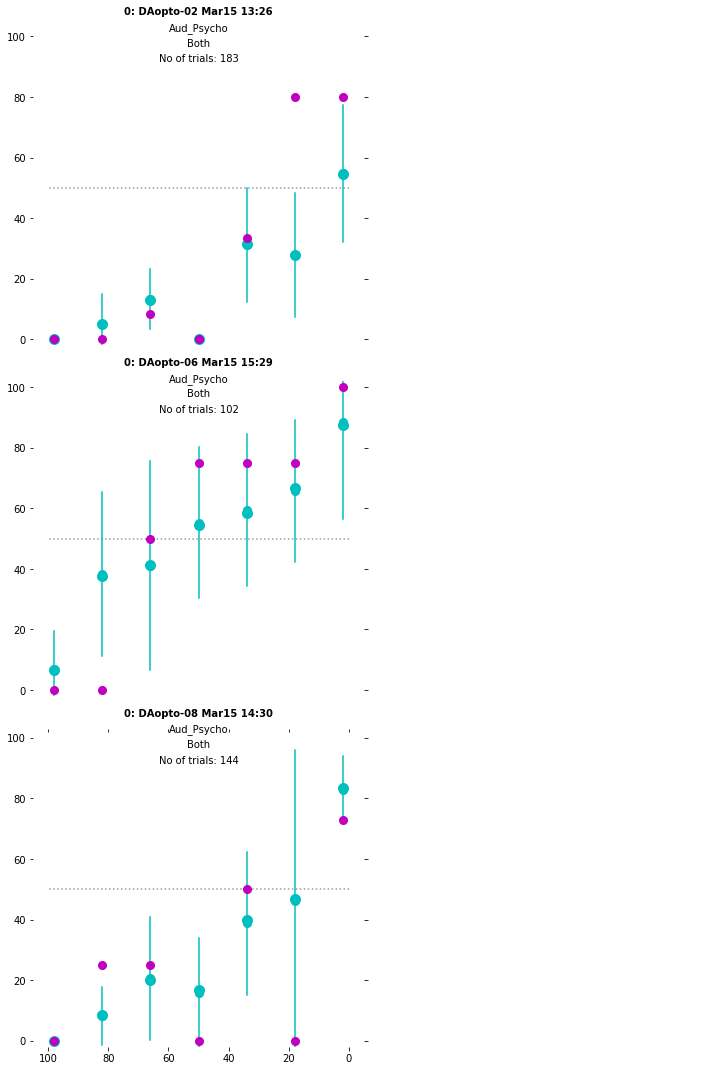

In [69]:
# Plot the data with the error bars for the random sampling

# CondList = [(pulledData['PreviousOpto']==0),
#             (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Previous Normal', 'Previous Opto']

# n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
n_cols = 2

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)

if selected_prev_side == 1:
    sps_str = 'left'
if selected_prev_side == 2:
    sps_str = 'right'

plt.savefig(outputDir + output_directory_name + \
            '_difficulty_significance_for_individual_opto_sessions_previous_nAc_previous-' + sps_str + '.pdf',
            transparent=True, bbox_inches='tight')

plt.show(fig)